In [1]:
import numpy as np, healpy as hp, curvedsky as cs, sys, plottools as pl, local, tools_cmbalm, tqdm, tools_lens, quad_func, pickle
from pixell import enmap
from matplotlib.pyplot import *

/global/homes/t/toshiyan/Work/Lib/actlib/actsims/actsims/noise.py:9: UserWarning: No pyfftw found. Using much slower numpy fft engine.
  if 'fftw' not in pfft.engine: warnings.warn("No pyfftw found. Using much slower numpy fft engine.")


In [2]:
def quick_rec(alm,mask,ocl,lcl,rlmax=3000):
    wTmap = mask*cs.utils.hp_alm2map(2048,3000,3000,alm[:3001,:3001])
    wTlm = cs.utils.hp_map2alm(2048,3000,3000,wTmap)
    fTlm = wTlm[:rlmax+1,:rlmax+1]/(ocl[:rlmax+1,None]+1e-30)
    klm, __ = cs.rec_lens.qtt(2048,500,rlmax,lcl[:rlmax+1],fTlm,fTlm,gtype='k')
    kl = cs.utils.alm2cl(2048,klm)
    return klm, kl

In [13]:
def cartmap(Tlm,ocl,mask=1,lmin=500,lmax=3000,v=2e13,nside=512,lonra=[145,245],latra=[-5,22]):
    Flm = Tlm*0.
    Flm[lmin:,:] = 1.
    #Tmap = cs.utils.hp_alm2map(nside,lmax,lmax,Tlm[:lmax+1,:lmax+1])
    Tmap = cs.utils.hp_alm2map(nside,lmax,lmax,Flm[:lmax+1,:lmax+1]*Tlm[:lmax+1,:lmax+1]/(ocl[:lmax+1,None]+1e-30))
    print(np.average(Tmap**2))
    hp.cartview(mask*Tmap,lonra=lonra,latra=latra,min=-v,max=v)

In [43]:
def create_mask(nside,lon,lat,theta,phi):
    mask = np.zeros(12*nside**2)
    mask[lon[0]>=theta] = 1.
    mask[lon[1]<=theta] = 1.
    mask[lat[0]>=phi] = 1.
    mask[lat[1]<=phi] = 1.
    return mask

In [4]:
kwargs = {'snmin':0,'snmax':10}
kwargs_ov = {'overwrite':True}
kwargs_qrec = {'n0max':5,'mfmax':10,'rlmin':500,'qlist':['TT'],'bhe':['src']}
#kwargs_qrec = {'n0max':5,'mfmax':10,'rlmin':500,'qlist':['TT']}

In [5]:
aobj = local.init_analysis_params(qid='diff_boss_03',**kwargs)
cobj = local.init_analysis_params(qid='comb_dn',**kwargs)
dirs = local.data_directory()
qobj = quad_func.reconstruction(dirs['local'],aobj.ids,stag=aobj.stag,**kwargs_qrec)
ocl = (np.loadtxt(cobj.fscl['c'])).T[1]

In [6]:
pixel_theta, pixel_phi = hp.pix2ang(2048, np.arange(12*2048**2), lonlat=True)

In [7]:
mask_iv = tools_cmbalm.load_mask('boss_d03',with_ivar=False)
mask_hp = enmap.to_healpix(mask_iv,nside=2048)[0]

In [8]:
Tlm = pickle.load(open(aobj.falm['c']['T'][0],"rb"))
tlm = pickle.load(open(aobj.falm['c']['T'][1],"rb"))

In [9]:
l, gl, cl, xl = np.loadtxt(qobj.f['TT'].cl[1],unpack=True,usecols=(0,1,2,3))
print(qobj.f['TT'].cl[1])
l, Gl, Cl, Xl = np.loadtxt(qobj.f['TT'].cl[0],unpack=True,usecols=(0,1,2,3))

/global/homes/t/toshiyan/Work/Ongoing/act_lens/data_local/lens/aps/rlz/cl_TT_diff_boss_03_base_a1.0deg_none_bh-src_l500-3000_00000.dat


2.1802807606787004e+24


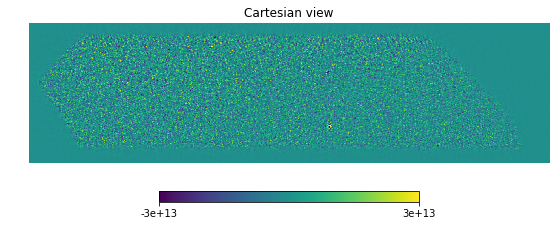

In [14]:
cartmap(Tlm,ocl,mask=1,lmin=2000,v=3e13)

2.1803845963012665e+24


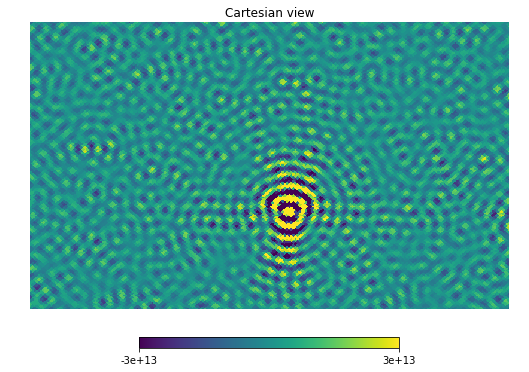

In [51]:
cartmap(Tlm,ocl,mask=1,lmin=2000,v=3e13,lonra=[185,190],latra=[1,4],nside=2048)

2.1803845963012665e+24


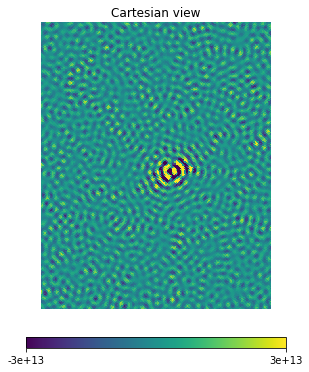

In [50]:
cartmap(Tlm,ocl,mask=1,lmin=2000,v=3e13,lonra=[186,190],latra=[10,15],nside=2048)

2.1803845963012665e+24


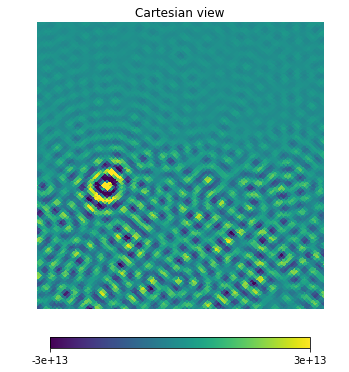

In [45]:
cartmap(Tlm,ocl,mask=1,lmin=2000,v=3e13,lonra=[207,210],latra=[18,21],nside=2048)

2.1803845963012665e+24


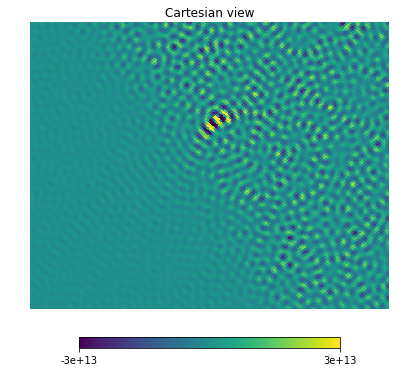

In [46]:
cartmap(Tlm,ocl,mask=1,lmin=2000,v=3e13,lonra=[235,240],latra=[0,4],nside=2048)

2.1803845963012665e+24


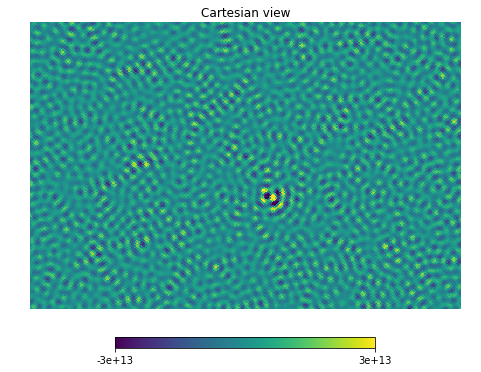

In [70]:
cartmap(Tlm,ocl,mask=1,lmin=2000,v=3e13,lonra=[162,168],latra=[0,4],nside=2048)

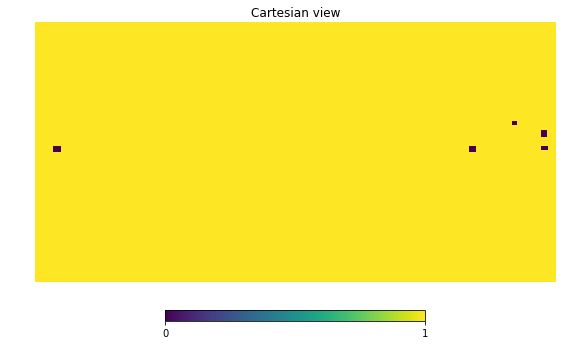

In [72]:
mask0 = create_mask(2048,[185,190],[1,4],pixel_theta,pixel_phi)
mask1 = create_mask(2048,[186,190],[10,15],pixel_theta,pixel_phi)
mask2 = create_mask(2048,[207,210],[18,21],pixel_theta,pixel_phi)
mask3 = create_mask(2048,[235,240],[0,4],pixel_theta,pixel_phi)
mask4 = create_mask(2048,[162,168],[0,4],pixel_theta,pixel_phi)
mask_ptsr = mask0*mask1*mask2*mask3*mask4
maskd = hp.ud_grade(mask_ptsr,512)
hp.cartview(mask_ptsr)

In [73]:
Klm, Kl = quick_rec(Tlm,mask_hp*mask_ptsr,ocl,aobj.lcl[0],rlmax=3000)

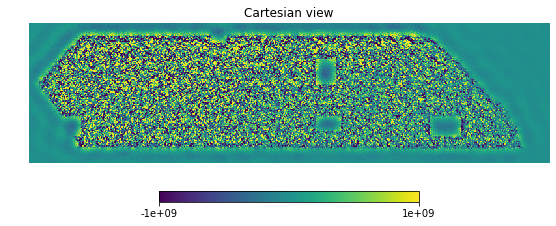

In [74]:
Klm[:100,:] = 0
Kmap = cs.utils.hp_alm2map(512,1024,1024,Klm[:1025,:1025])
hp.cartview(Kmap,lonra=[145,245],latra=[-5,22],min=-1e9,max=1e9)
#hp.cartview(Kmap,lonra=[150,170],latra=[-5,5],min=-1e9,max=1e9)

In [75]:
klm, kl = quick_rec(tlm,mask_hp*mask_ptsr,ocl,aobj.lcl[0],rlmax=3000)

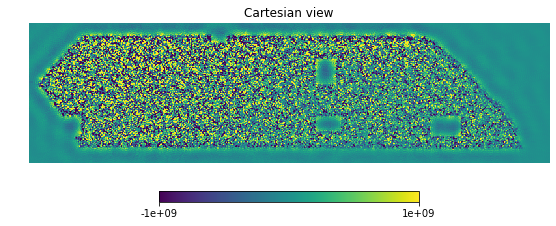

In [76]:
klm[:100,:] = 0
kmap = cs.utils.hp_alm2map(512,1024,1024,klm[:1025,:1025])
hp.cartview(kmap,lonra=[145,245],latra=[-5,22],min=-1e9,max=1e9)

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


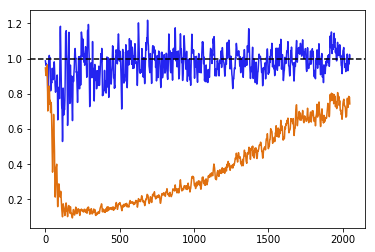

In [77]:
plot(kl/Kl)
plot(l,gl/Gl)
axhline(1,color='k',ls='--')